In [2]:
## Testing
print("hello")

hello


In [3]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data
raw_df = pd.read_parquet("../data/raw/online_retail.parquet",engine="fastparquet")


In [4]:
## Clean the raw data

In [5]:
## Exploratory Data Analysis - DO NOT INCLUDE IN PIPELINE
raw_df.head() ## 500K rows, which are line items for invoices.
raw_df.describe() ## Negative quantity and price metrics, likely refunds. Should be removed.
(raw_df["Price"] < 0).sum() ## 3 line items are negative, so will remove these.
raw_df.info() ## There are about 100K line items that are null.
raw_df.isnull().sum() ## Nulls are all in customer ID feature.
raw_df.shape # Shape before cleaning.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  525461 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


(525461, 8)

In [6]:
## Full dataset cleaning
full_df = raw_df[(raw_df["Price"] >= 0) & (raw_df["Quantity"] >= 0)].dropna(subset=["Customer ID"])
full_df.shape # Shape after cleaning. Looks like there were an additional 10K rows removed for negative price and quantity.

(407695, 8)

In [7]:
full_df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [8]:
## Group into customer-level dataframe

## First create lineitem_amount column
full_df["lineitem_amount"] = full_df["Quantity"] * full_df["Price"]
full_df.head(20)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,lineitem_amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.60
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.50
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.00


In [9]:
## Get max date within the entire dataset as reference for 'today'
MAX_DATE = full_df["InvoiceDate"].max().normalize()
print(MAX_DATE)

2010-12-09 00:00:00


In [10]:
## Check on results
full_df["Invoice"].str.startswith("C").describe() 
full_df["Invoice"].str.startswith("c").describe() ## According to this, no invoices were cancelled

count     407695
unique         1
top        False
freq      407695
Name: Invoice, dtype: object

In [11]:
## Create invoice df
invoice_df = (
    full_df
    .assign(InvoiceDate=full_df["InvoiceDate"].dt.normalize())
    .groupby(["Customer ID", "InvoiceDate"], as_index=False)
    .agg(
        monetary=("lineitem_amount", "sum")
        # Frequency=("Invoice", "nunique") # This captures multiple invoices for customer in same day, which we don't care about
    )
)


In [12]:
## Sort by customer, then date to help get interpurchase days
invoice_df = invoice_df.sort_values(["Customer ID", "InvoiceDate"])
invoice_df.head()

,Customer ID,InvoiceDate,monetary
0,12346.0,2009-12-14,90.0
1,12346.0,2009-12-18,23.5
2,12346.0,2010-01-04,45.0
3,12346.0,2010-01-14,22.5
4,12346.0,2010-01-22,22.5


In [13]:
## Calculate interpurchase days
invoice_df["days_between_purchases"] = (
    invoice_df
    .groupby("Customer ID")["InvoiceDate"]
    .diff()
    .dt.days
)
invoice_df.head(20)

,Customer ID,InvoiceDate,monetary,days_between_purchases
0,12346.0,2009-12-14,90.00,NaN
1,12346.0,2009-12-18,23.50,4.0
2,12346.0,2010-01-04,45.00,17.0
3,12346.0,2010-01-14,22.50,10.0
4,12346.0,2010-01-22,22.50,8.0
5,12346.0,2010-03-02,27.05,39.0
6,12346.0,2010-06-28,142.31,118.0
7,12347.0,2010-10-31,611.53,NaN
8,12347.0,2010-12-07,711.79,37.0
9,12348.0,2010-09-27,222.16,NaN


In [14]:
## Create customer df, with core aggregations
customer_df = (
    invoice_df
    .groupby("Customer ID")
    .agg(
        customer_id=("Customer ID", "first"),

        # Recency: days since most recent invoice
        recency=("InvoiceDate", lambda x: (MAX_DATE - x.max().normalize()).days),

        # Frequency: number of invoices
        frequency=("InvoiceDate", "count"),

        # Monetary: total spend
        monetary=("monetary", "sum"),

        # Median days between purchases
        median_purchase_days=("days_between_purchases", "median")
    )
    .reset_index(drop=True)
)

In [15]:
## For medians NaN, just put in ithe recency (only one purchase)
customer_df["median_purchase_days"] = (
    customer_df["median_purchase_days"]
    .fillna(customer_df["recency"])
)
customer_df.head()

,customer_id,recency,frequency,monetary,median_purchase_days
0,12346.0,164,7,372.86,13.5
1,12347.0,2,2,1323.32,37.0
2,12348.0,73,1,222.16,73.0
3,12349.0,42,3,2671.14,91.0
4,12351.0,10,1,300.93,10.0


In [16]:
## Add churn ratio
customer_df["churn_ratio"]=customer_df["recency"]/customer_df["median_purchase_days"]
customer_df.head()

,customer_id,recency,frequency,monetary,median_purchase_days,churn_ratio
0,12346.0,164,7,372.86,13.5,12.148148
1,12347.0,2,2,1323.32,37.0,0.054054
2,12348.0,73,1,222.16,73.0,1.000000
3,12349.0,42,3,2671.14,91.0,0.461538
4,12351.0,10,1,300.93,10.0,1.000000


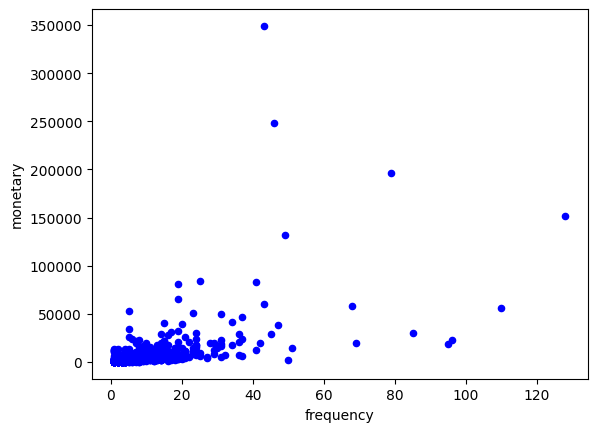

In [17]:
## Look at data to see if need to log monetary or other skews
customer_df.plot.scatter(x="frequency", y="monetary", color="blue")
plt.show() ## Probably, but transformation looks strange and want interpretation to be clean for client

In [18]:
## Create the kmeans df with normalization
customer_df['monetary_log'] = np.log1p(customer_df['monetary'])
kmeans_df=customer_df[["recency","frequency","monetary_log"]]
kmeans_df.head()

## Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(kmeans_df)

## Determine k parameter via elbow method
from sklearn.cluster import KMeans
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

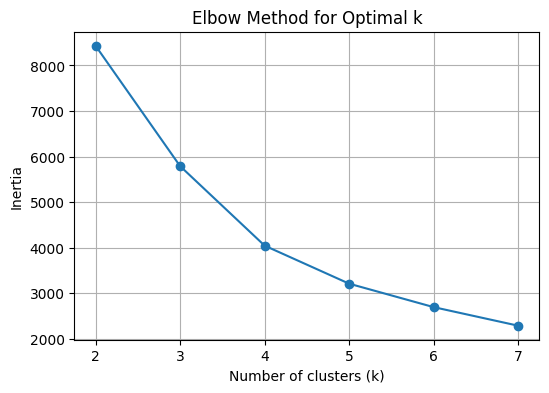

In [19]:
## Elbow plot
ks = list(range(2, 8))
plt.figure(figsize=(6,4))
plt.plot(ks, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(ks)
plt.grid(True)
plt.show() # Chose 3 where drop off occurs

In [20]:
## Fit kmeans with 4 clusters
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

result = kmeans.fit_predict(X) ## Array of cluster assignments


In [21]:
## Determine segment names for the customer data frame
customer_df["cluster_assignment"]=result
customer_df.head()

,customer_id,recency,frequency,monetary,median_purchase_days,churn_ratio,monetary_log,cluster_assignment
0,12346.0,164,7,372.86,13.5,12.148148,5.923881,2
1,12347.0,2,2,1323.32,37.0,0.054054,7.188654,0
2,12348.0,73,1,222.16,73.0,1.000000,5.407889,0
3,12349.0,42,3,2671.14,91.0,0.461538,7.890635,0
4,12351.0,10,1,300.93,10.0,1.000000,5.710195,0


In [22]:
## Make inferences about clusters
cluster_summary = (
    customer_df
    .groupby('cluster_assignment')
    .agg(
        avg_recency=('recency', 'mean'),
        avg_frequency=('frequency', 'mean'),
        avg_monetary=('monetary', 'mean'),
        customers=('customer_id', 'count')
    )
)
cluster_summary

,avg_recency,avg_frequency,avg_monetary,customers
cluster_assignment,,,,
0,50.094501,2.507943,824.118771,2455
1,25.695150,10.915704,7347.131291,866
2,245.911380,1.400806,449.321243,993


In [23]:
## Customer segment assignment
cluster_map = {
    0: 'Seasonal Buyers',
    1: 'Monthly, High-Value Buyers',
    2: 'Experimental / Hesitant, Lower-Value Buyers'
}

customer_df['segment'] = customer_df['cluster_assignment'].map(cluster_map)
customer_df.head()

,customer_id,recency,frequency,monetary,median_purchase_days,churn_ratio,monetary_log,cluster_assignment,segment
0,12346.0,164,7,372.86,13.5,12.148148,5.923881,2,"Experimental / Hesitant, Lower-Value Buyers"
1,12347.0,2,2,1323.32,37.0,0.054054,7.188654,0,Seasonal Buyers
2,12348.0,73,1,222.16,73.0,1.000000,5.407889,0,Seasonal Buyers
3,12349.0,42,3,2671.14,91.0,0.461538,7.890635,0,Seasonal Buyers
4,12351.0,10,1,300.93,10.0,1.000000,5.710195,0,Seasonal Buyers


In [24]:
## Sanity check segmentation
customer_df.groupby('segment')['monetary'].sum()

segment
Experimental / Hesitant, Lower-Value Buyers     446175.994
Monthly, High-Value Buyers                     6362615.698
Seasonal Buyers                                2023211.582
Name: monetary, dtype: float64

In [25]:
## Visualize segmentation
import plotly.express as px

fig=px.scatter(
    customer_df,
    x='frequency',
    y='monetary',
    color='segment',
    size='recency',
    hover_data=["customer_id"]
)
# Increase figure size and make axes readable
fig.update_layout(
    width=900,
    height=600,
    title='Customer Segmentation (RFM)',
    xaxis_title='Frequency',
    yaxis_title='Monetary (£)',
    font=dict(size=14)
)

fig.show()

In [26]:
## Read the data back to CSV
customer_df.to_csv("../data/processed/customer_df.csv")
invoice_df.to_csv("../data/processed/invoice_df.csv")
full_df.to_csv("../data/processed/full_df.csv")

In [ ]:
    # Add churn label based on churn_ratio
    def assign_churn_label(ratio):
        """Assign churn risk label based on churn ratio."""
        if pd.isna(ratio) or not np.isfinite(ratio):
            return None
        if ratio <= 1:
            return "Low Risk"
        elif ratio < 2:
            return "Medium Risk"
        else:  # ratio >= 2
            return "High Risk"
    
    customer_df["churn_label"] = customer_df["churn_ratio"].apply(assign_churn_label)
    # customer_df.head(10)

In [32]:
## Create visualization of churn ratio x monetary
import plotly.express as px
import plotly.graph_objects as go

# Filter extreme outliers for better visualization
churn_q95 = customer_df['churn_ratio'].quantile(0.95)
monetary_q95 = customer_df['monetary'].quantile(0.95)

customer_df_viz = customer_df[
    (customer_df['churn_ratio'] <= churn_q95) & 
    (customer_df['monetary'] <= monetary_q95)
].copy()

# Create the scatter plot
fig = px.scatter(
    customer_df_viz,
    x='churn_ratio',
    y='monetary',
    color='segment',
    hover_data=["customer_id", "churn_label"],
    title='Churn Ratio vs Monetary Value by Segment'
)

# Add vertical lines for churn ratio thresholds
fig.add_vline(
    x=1,
    line_dash="dash",
    line_color="red",
    line_width=2,
    annotation_text="Low/Medium Threshold",
    annotation_position="top"
)

fig.add_vline(
    x=2,
    line_dash="dash",
    line_color="orange",
    line_width=2,
    annotation_text="Medium/High Threshold",
    annotation_position="top"
)

# Add background regions for risk zones
y_min = customer_df_viz['monetary'].min()
y_max = customer_df_viz['monetary'].max()

fig.add_hrect(
    y0=y_min,
    y1=y_max,
    x0=0,
    x1=1,
    fillcolor="green",
    opacity=0.1,
    layer="below",
    line_width=0
)

fig.add_hrect(
    y0=y_min,
    y1=y_max,
    x0=1,
    x1=2,
    fillcolor="orange",
    opacity=0.1,
    layer="below",
    line_width=0
)

fig.add_hrect(
    y0=y_min,
    y1=y_max,
    x0=2,
    x1=customer_df_viz['churn_ratio'].max(),
    fillcolor="red",
    opacity=0.1,
    layer="below",
    line_width=0
)

# Add text labels for risk regions below the x-axis
fig.add_annotation(
    x=0.5,
    y=-0.08,
    xref="x",
    yref="paper",
    text="Low Risk",
    showarrow=False,
    font=dict(size=14, color="green")
)

fig.add_annotation(
    x=1.5,
    y=-0.08,
    xref="x",
    yref="paper",
    text="Medium Risk",
    showarrow=False,
    font=dict(size=14, color="orange")
)

fig.add_annotation(
    x=2.5,
    y=-0.08,
    xref="x",
    yref="paper",
    text="High Risk",
    showarrow=False,
    font=dict(size=14, color="red")
)

# Update layout with focused ranges
fig.update_layout(
    width=1000,
    height=700,
    xaxis_title='Churn Ratio',
    yaxis_title='Monetary (£)',
    font=dict(size=14),
    margin=dict(b=80),
    # Set ranges to focus on the relevant area
    xaxis=dict(
        range=[-0.5, min(5, customer_df_viz['churn_ratio'].max() * 1.1)]  # Add padding
    ),
    yaxis=dict(
        range=[0, customer_df_viz['monetary'].max() * 1.1]  # Add padding
    )
)

fig.show()